In [1]:
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

### Moving Average Convergence Divergence (MACD)

In [2]:
ticker = "MSFT"
df = yf.download(ticker,dt.date.today()-dt.timedelta(365),dt.datetime.today())

def MACD(DF,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    df = DF.copy()
    df["MA_Fast"]=df["Adj Close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df["Adj Close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    df.dropna(inplace=True)
    return df

[*********************100%***********************]  1 of 1 completed


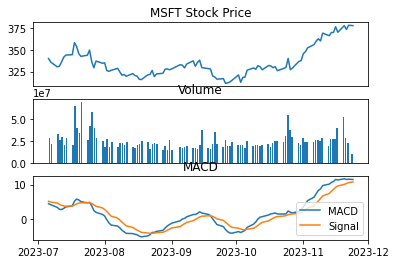

Text(0.5, 0.98, 'Stock Price with MACD')

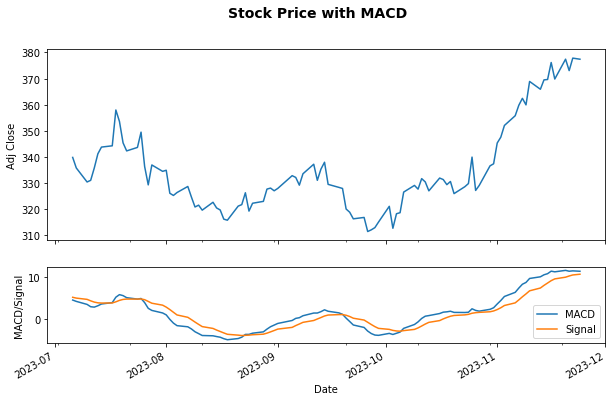

In [3]:
# Visualization - plotting MACD/signal along with close price and volume for last 100 data points
output = MACD(df, 12, 26, 9)

plt.subplot(311)
plt.plot(output.iloc[-100:,4])
plt.title(f"{ticker} Stock Price")
plt.xticks([])

plt.subplot(312)
plt.bar(output.iloc[-100:,5].index, df.iloc[-100:,5].values)
plt.title('Volume')
plt.xticks([])

plt.subplot(313)
plt.plot(output.iloc[-100:,[-2,-1]])
plt.title('MACD')
plt.legend(('MACD','Signal'),loc='lower right')

plt.show()


# Visualization - Using object orient approach
# Get the figure and the axes
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, sharey=False, figsize=(10, 6), gridspec_kw = {'height_ratios':[2.5, 1]})
output.iloc[-100:,4].plot(ax=ax0)
ax0.set(ylabel='Adj Close')

output.iloc[-100:,[-2,-1]].plot(ax=ax1)
ax1.set(xlabel='Date', ylabel='MACD/Signal')

# Title the figure
fig.suptitle('Stock Price with MACD', fontsize=14, fontweight='bold')

### Bollinger Bands and Average True Range(ATR)

In [4]:
def ATR(DF,n=14):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def BollingerBand(DF,n=20):
    "function to calculate Bollinger Band"
    df = DF.copy()
    df["MA"] = df['Adj Close'].rolling(n).mean()
    #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_up"] = df["MA"] + 2*df['Adj Close'].rolling(n).std(ddof=0)
    #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_dn"] = df["MA"] - 2*df['Adj Close'].rolling(n).std(ddof=0)
    df["BB_width"] = df["BB_up"] - df["BB_dn"]
    df.dropna(inplace=True)
    return df

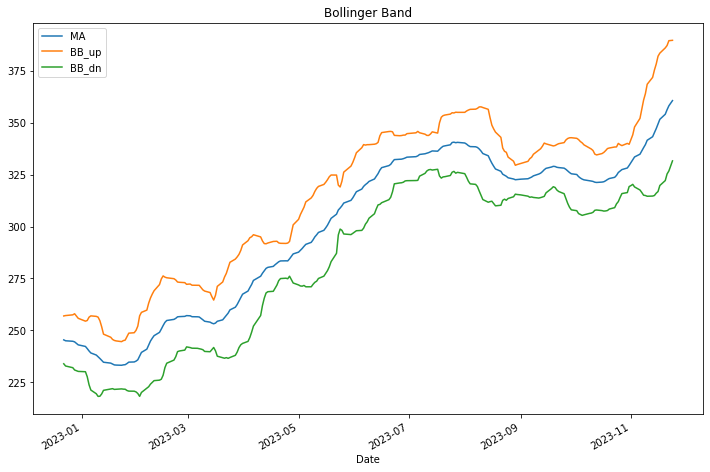

In [5]:
BollingerBand(df).iloc[:,-4:-1].plot(title="Bollinger Band", figsize=(12,8))
plt.show()

In [6]:
def RSI_1(DF,n=14):
    "function to calculate RSI"
    df = DF.copy()
    df['delta']=df['Adj Close'] - df['Adj Close'].shift(1)
    df['gain']=np.where(df['delta']>=0,df['delta'],0)
    df['loss']=np.where(df['delta']<0,abs(df['delta']),0)
    avg_gain = []
    avg_loss = []
    gain = df['gain'].tolist()
    loss = df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i == n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i > n:
            avg_gain.append(((n-1)*avg_gain[i-1] + gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1] + loss[i])/n)
    df['avg_gain']=np.array(avg_gain)
    df['avg_loss']=np.array(avg_loss)
    df['RS'] = df['avg_gain']/df['avg_loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    return df

def RSI(DF, n=14):
    "function to calculate RSI with ewm"
    df = DF.copy()
    delta = df["Adj Close"].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n]) # first value is average of gains
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n]) # first value is average of losses
    d = d.drop(d.index[:(n-1)])
    rs = u.ewm(com=n,min_periods=n).mean()/d.ewm(com=n,min_periods=n).mean()
    df["RSI"] = 100 - 100 / (1+rs)
    return df

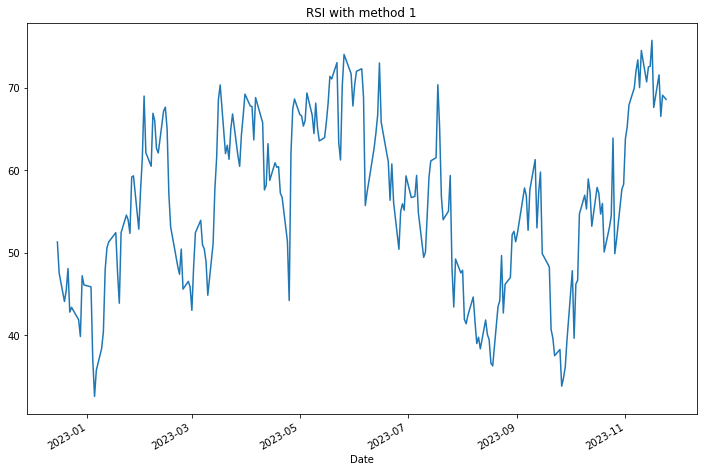

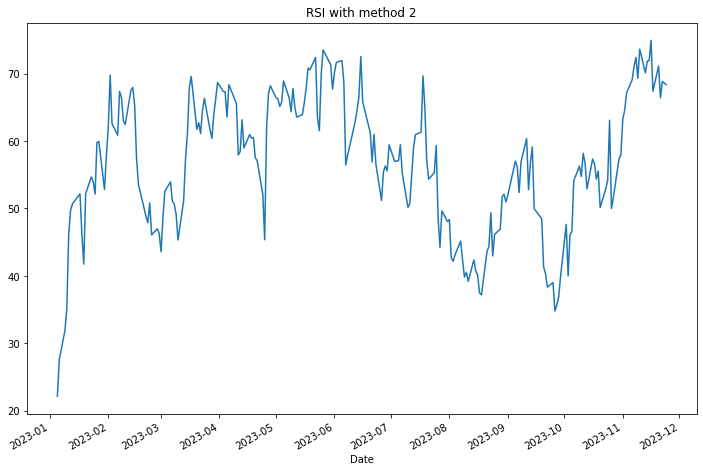

In [7]:
RSI_1(df).iloc[:,-1].plot(title="RSI with method 1", figsize=(12,8))
plt.show()
RSI(df).iloc[:,-1].plot(title="RSI with method 2", figsize=(12,8))
plt.show()